In [319]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [340]:
from statistics import mean 
from scipy import stats as kl
from math import log,pi
from decimal import Decimal
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import math

In [341]:
A = ['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
M = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
F = ['count', 'sum', 'avg', 'min', 'max']

In [342]:
def query_rewriting_final(a):
    #As mentioned on campuswire
    query = 'select ' + a + ','
    for m in M:
        for f in F:
            query = query + ' ' + f + '(' + m + ') as ' + f + '_' + m + ','
    
    query = query + ' case when marital_status like \'%Married-civ-spouse%\' then 1 when marital_status like \'%Married-AF-spouse%\' then 1 when marital_status like \'%Married-spouse-absent%\' then 1 when marital_status like \'%Widowed%\' then 1 when marital_status like \'%Separated%\' then 1 else 0 end as married from adults where ' + a + ' is not null group by ' + a + ', married;'

    return query


In [343]:
queries = []
for a in A:
    queries.append(query_rewriting_final(a))

In [344]:
conn = psycopg2.connect(database = "miniproject", user = "surajjain", host= 'localhost', password = "xxx", port = 5432)

print(conn)
cur = conn.cursor()


<connection object at 0x14ea6d040; dsn: 'user=surajjain password=xxx dbname=miniproject host=localhost port=5432', closed: 0>


## SHARED BASED OPTIMIZATION (Query rewriting)

In [349]:
def query_rewriting_final(a):
    #As mentioned on campuswire
    query = 'select ' + a + ','
    for m in M:
        for f in F:
            query = query + ' ' + f + '(' + m + ') as ' + f + '_' + m + ','
    
    query = query + ' case when marital_status like \'%Married-civ-spouse%\' then 1 when marital_status like \'%Married-AF-spouse%\' then 1 when marital_status like \'%Married-spouse-absent%\' then 1 when marital_status like \'%Widowed%\' then 1 when marital_status like \'%Separated%\' then 1 else 0 end as married from adults where ' + a + ' is not null group by ' + a + ', married;'

    return query

queries = []
for a in A:
    queries.append(query_rewriting_final(a))


In [350]:
kl_dict = defaultdict(list)
for a in A:
    final_query = query_rewriting_final(a)
    #print(final_query)
    cur.execute(final_query)
    q_rows = cur.fetchall()
    t = pd.DataFrame(q_rows)
    t.columns = [desc[0] for desc in cur.description]
    for m in M:
        for f in F:
            sum_unmarried = Decimal(0.0)
            sum_married = Decimal(0.0)
            distinct_a = t[a].unique()
            #print(distinct_a)
            view_desc = "" + f + '_' + m
            for index, row in t.iterrows():
                if row[view_desc] == 0:
                    row[view_desc] = 1e-10
                if row["married"] == 0:
                    ch = 0
                    for d_a in distinct_a:
                        if d_a == row[a]:
                            ch = 1
                            break
                    if ch == 0:
                        row[view_desc] = 1e-10

                    sum_unmarried = sum_unmarried + Decimal(row[view_desc])
                else:
                    ch = 0
                    for d_a in distinct_a:
                        if d_a == row[a]:
                            ch = 1
                            break
                    if ch == 0:
                        row[view_desc] = 1e-10
                    sum_married = sum_married + Decimal(row[view_desc])

            married_prob = {}
            unmarried_prob = {}
            for index, row in t.iterrows():
                if row["married"] == 0:
                    unmarried_prob[row[a]] = row[view_desc] / sum_unmarried
                else:
                    married_prob[row[a]] = row[view_desc] / sum_married

            for d_a in distinct_a:
                if d_a not in unmarried_prob.keys():
                    unmarried_prob[d_a] = Decimal(1e-10) / sum_unmarried
                if d_a not in married_prob.keys():
                    married_prob[d_a] = Decimal(1e-10) / sum_married
            
            kl_div = Decimal(0.0)
            for k in married_prob.keys():
                if k in unmarried_prob.keys():
                    if unmarried_prob[k] == 0:
                        continue
                    else:
                        ratio = married_prob[k] / unmarried_prob[k]
                        if ratio > 0:
                            kl_div = kl_div + (Decimal(married_prob[k]) * Decimal(math.log(ratio)))
                else:
                    kl_div = kl_div + (Decimal(married_prob[k]) * Decimal(math.log(married_prob[k] / Decimal(1e-10))))

            #print(kl_div)
            kl_dict[a,m,f] = kl_div


shared_optimization_result = sorted(kl_dict.items(), key= lambda item: item[1], reverse=True)[:5]
print(shared_optimization_result)
            

    


[(('relationship', 'fnlwgt', 'sum'), Decimal('37.36377912897473971575656436')), (('relationship', 'capital_gain', 'sum'), Decimal('36.48175980820815885120608396')), (('relationship', 'capital_loss', 'sum'), Decimal('33.09357855920874034924120967')), (('relationship', 'hours_per_week', 'sum'), Decimal('31.07213277683926485735619604')), (('relationship', 'age', 'sum'), Decimal('29.84349226258839347077911096'))]


## PRUNING BASED OPTIMIZATION

In [351]:
V = []
for a in A:
    for m in M:
        for f in F:
            V.append((a, m, f))

In [352]:
def evaluate(dfs,all_views):
    kl_dict = defaultdict(list)
    for (a,m,f) in all_views:
        for df in dfs:
            sum_unmarried = Decimal(0.0)
            sum_married = Decimal(0.0)
            if a not in df:
                continue
            distinct_a = df[a].unique()
            view_desc = "" + f + '_' + m
            for index, row in df.iterrows():
                if row[view_desc] == 0:
                    row[view_desc] = 1e-10
                if row["married"] == 0:
                    ch = 0
                    for d_a in distinct_a:
                        if d_a == row[a]:
                            ch = 1
                            break
                    if ch == 0:
                        row[view_desc] = 1e-10

                    sum_unmarried = sum_unmarried + Decimal(row[view_desc])
                else:
                    ch = 0
                    for d_a in distinct_a:
                        if d_a == row[a]:
                            ch = 1
                            break
                    if ch == 0:
                        row[view_desc] = 1e-10
                    sum_married = sum_married + Decimal(row[view_desc])

            married_prob = {}
            unmarried_prob = {}
            for index, row in df.iterrows():
                if row["married"] == 0:
                    unmarried_prob[row[a]] = row[view_desc] / sum_unmarried
                else:
                    married_prob[row[a]] = row[view_desc] / sum_married

            for d_a in distinct_a:
                if d_a not in unmarried_prob.keys():
                    if sum_unmarried == 0:
                        unmarried_prob[d_a] = Decimal(1e-13)
                    else:
                        unmarried_prob[d_a] = Decimal(1e-10) / sum_unmarried
                if d_a not in married_prob.keys():
                    if sum_married == 0:
                        married_prob[d_a] = Decimal(1e-13)
                    else:                   
                        married_prob[d_a] = Decimal(1e-10) / sum_married
            
            kl_div = Decimal(0.0)
            for k in married_prob.keys():
                if k in unmarried_prob.keys():
                    if unmarried_prob[k] == 0:
                        continue
                    else:
                        ratio = married_prob[k] / unmarried_prob[k]
                        if ratio > 0:
                            kl_div = kl_div + (Decimal(married_prob[k]) * Decimal(math.log(ratio)))
                else:
                    kl_div = kl_div + (Decimal(married_prob[k]) * Decimal(math.log(married_prob[k] / Decimal(1e-10))))

            #print(kl_div)
            kl_dict[a,m,f].append(kl_div)

    return kl_dict



In [353]:
num_partitions = 4

def confidence(m,N,delta):
    return math.sqrt(((1-((m-1)/N))*(2*log(log(m))) + log((pi*pi)/(3*delta)))/(2*m))

def intervals(x):
    temp = defaultdict(dict)
    for k,v in x.items():
        temp[k]['mean'] = sum(v)/len(v)
        width = confidence(len(x[k]),num_partitions,0.01)
        temp[k]['upper_bound'] = temp[k]['mean'] + Decimal(width)
        temp[k]['lower_bound'] = temp[k]['mean'] - Decimal(width)
    return temp
        


In [354]:
df_list = []
for a in A:
    final_query = query_rewriting_final(a)
    cur.execute(final_query)
    q_rows = cur.fetchall()
    t = pd.DataFrame(q_rows)
    t.columns = [desc[0] for desc in cur.description]
    df_list.append(t)
    
temp1 = []

for i in range(len(df_list)):
    partitions = np.array_split(df_list[i], num_partitions)
    partition_dfs = [pd.DataFrame(partition, columns=df_list[i].columns) for partition in partitions]
    temp1.append(partition_dfs)

df_list = []
for i in range(num_partitions):
    temp2 = []
    for j in range(len(temp1)):
        temp2.append(pd.DataFrame(temp1[j][i]))
    df_list.append(temp2)

ct = 0

final_results = defaultdict(list)
for i in range(num_partitions):
    partial_results = evaluate(df_list[i],V)
    for k,v in partial_results.items():
        final_results[k].append(v[0])

    ct+= 1
    if ct <=1:
        continue
    intervals_data = intervals(final_results)

    lower_bounds = []
    for p,q in intervals_data.items():
        lower_bounds.append(q['lower_bound'])
    lower_bounds = sorted(lower_bounds,reverse=True)
    if len(lower_bounds) >=5:
        fifth_lowest_bound = lower_bounds[4]
        for x,y in intervals_data.items():
            if y['upper_bound'] < fifth_lowest_bound:
                V.remove(x)
                del final_results[x]
        
temp = defaultdict(list)
for k,v in final_results.items():
    temp[k] = intervals_data[k]['mean']
    
pruning_optimization_result = sorted(temp.items(), key= lambda item: item[1], reverse=True)[:5]
print(pruning_optimization_result)


[(('relationship', 'fnlwgt', 'sum'), Decimal('28.76360161938110932136906402')), (('relationship', 'capital_gain', 'sum'), Decimal('26.4965109961911907081942956')), (('relationship', 'capital_loss', 'sum'), Decimal('25.10494271806378092221254755')), (('relationship', 'hours_per_week', 'sum'), Decimal('24.82008046925440263403370908')), (('relationship', 'age', 'sum'), Decimal('24.50100155749192615668464748'))]


## PLOTS

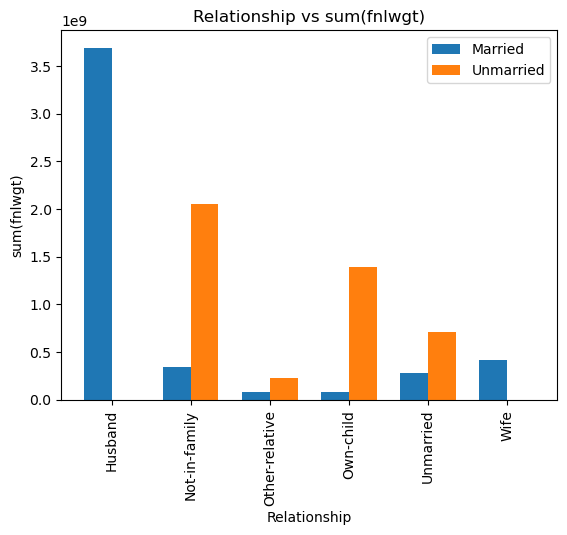

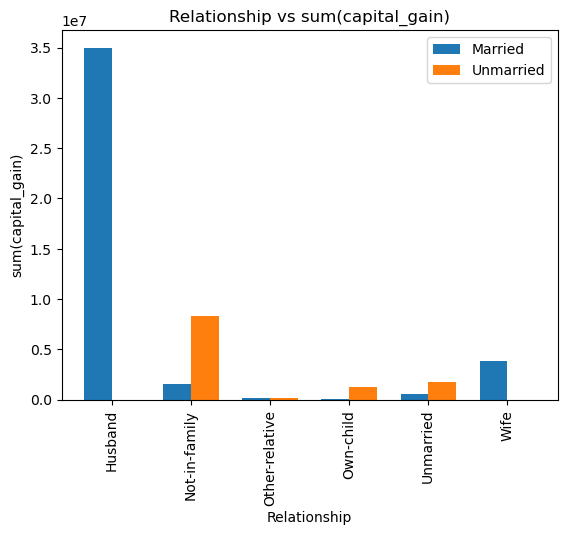

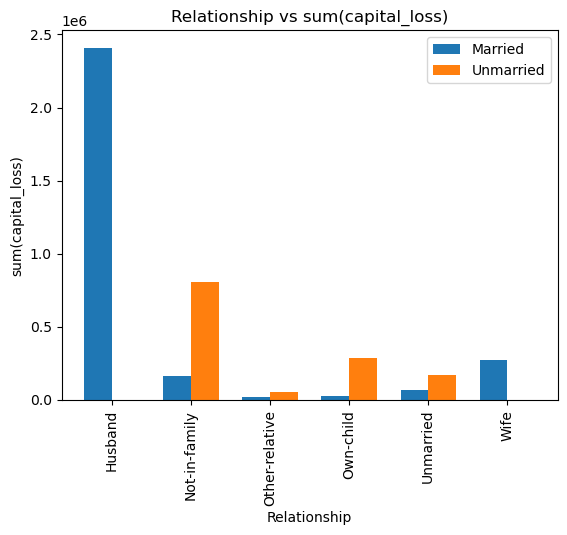

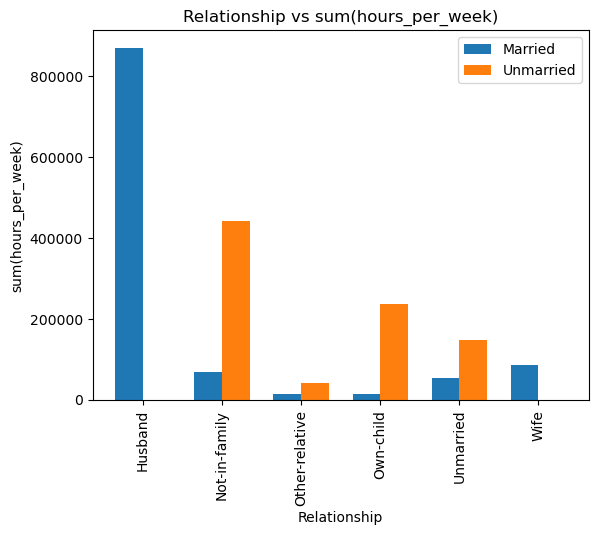

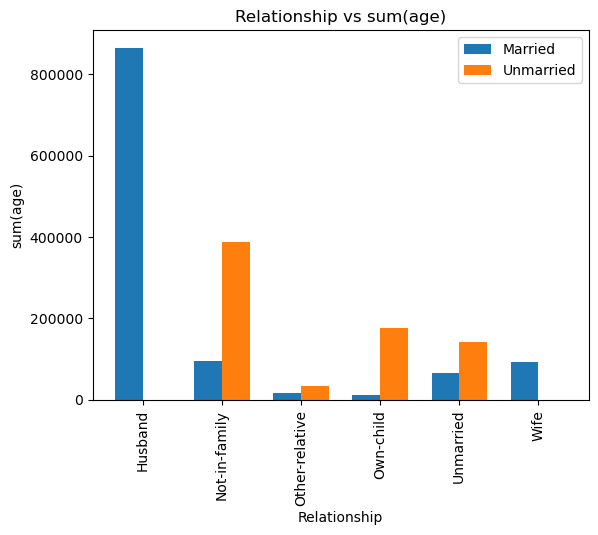

In [355]:
cur.execute(queries[3])
q_rows = cur.fetchall()
t = pd.DataFrame(q_rows)
t.columns = [desc[0] for desc in cur.description]

for i in shared_optimization_result:
    a,m,f = i[0]
    view_desc = "" + f + '_' + m
    ylabel = "" + f + '(' + m + ')'
    married_data ={}
    unmarried_data = {}
    distinct_a = t['relationship'].unique()

    for a in distinct_a:
        for index, row in t.iterrows():
            if row['relationship'] == a:
                if row['married'] == 1:
                    married_data[a] = row[view_desc]
                else:
                    unmarried_data[a] = row[view_desc]
    

    merged_data = married_data.copy()
    merged_data.update(unmarried_data)
    X = list(merged_data.keys())
    Y1 = [married_data.get(key, 0) for key in X]
    Y2 = [unmarried_data.get(key, 0) for key in X]

    width = 0.35
    x = np.arange(len(X))

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, Y1, width, label='Married')
    rects2 = ax.bar(x + width/2, Y2, width, label='Unmarried')

    ax.set_xlabel('Relationship')
    ax.set_ylabel(ylabel)
    ax.set_title('Relationship vs ' + ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(X, rotation=90)
    ax.legend()

    plt.show()

In [356]:
conn.commit()
cur.close()
conn.close()